**Advanced Machine Learning Group Project**   

Project by: Dean Carpenter, Rohan David, Sebastian Martinez, Simoni Dalal, Sreejony Sengupta

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
from tensorflow import keras
from tensorflow.keras import layers
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [ ]:
# Load raw merged datasets (store + features + train/test)
train_raw = pd.read_csv('train_features_all_merged.csv')
test_raw  = pd.read_csv('test_features_all_merged.csv')

# Tag source so we can join, engineer, then split again
train_raw['source'] = 'train'
test_raw['source']  = 'test'
full_df = pd.concat([train_raw, test_raw], ignore_index=True)

full_df['Date'] = pd.to_datetime(full_df['Date'])

# Combine duplicated holiday flags if present
if 'IsHoliday_x' in full_df.columns and 'IsHoliday_y' in full_df.columns:
    full_df['IsHoliday'] = full_df['IsHoliday_x'] | full_df['IsHoliday_y']
    full_df = full_df.drop(columns=['IsHoliday_x', 'IsHoliday_y'])

full_df['IsHoliday'] = full_df['IsHoliday'].astype(bool)

# Fill missing markdowns with 0 = "no promotion recorded"
markdown_cols = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
for col in markdown_cols:
    if col in full_df.columns:
        full_df[col] = full_df[col].fillna(0.0)

# --- Calendar features ---
full_df['Year']       = full_df['Date'].dt.year
full_df['Month']      = full_df['Date'].dt.month
full_df['Quarter']    = full_df['Date'].dt.quarter
full_df['WeekOfYear'] = full_df['Date'].dt.isocalendar().week.astype(int)
full_df['DayOfYear']  = full_df['Date'].dt.dayofyear
full_df['DayOfWeek']  = full_df['Date'].dt.dayofweek

# Total markdown “spend”
full_df['MarkDown_Total'] = full_df[markdown_cols].sum(axis=1)

# --- Lag & rolling features USE SHIFT(1) TO AVOID LEAKAGE
full_df = full_df.sort_values(['Store', 'Dept', 'Date'])
group = full_df.groupby(['Store', 'Dept'])

# Lags
full_df['lag_1_sales']  = group['Weekly_Sales'].shift(1)
full_df['lag_52_sales'] = group['Weekly_Sales'].shift(52)

# Rolling means / stds based on PAST values only
full_df['rolling_mean_4w']  = group['Weekly_Sales'].transform(
    lambda x: x.shift(1).rolling(window=4,  min_periods=1).mean()
)
full_df['rolling_mean_12w'] = group['Weekly_Sales'].transform(
    lambda x: x.shift(1).rolling(window=12, min_periods=1).mean()
)
full_df['rolling_std_4w']   = group['Weekly_Sales'].transform(
    lambda x: x.shift(1).rolling(window=4,  min_periods=1).std()
)

# Replace NaNs from std with 0 (no variation yet)
full_df['rolling_std_4w'] = full_df['rolling_std_4w'].fillna(0.0)

# Sharpe-like ratio: risk-adjusted sales
full_df['sharpe_4w'] = full_df['rolling_mean_4w'] / (full_df['rolling_std_4w'] + 1e-9)

# Early weeks with no history yet → encode as 0
full_df[['lag_1_sales', 'lag_52_sales']] = full_df[['lag_1_sales', 'lag_52_sales']].fillna(0.0)

# --- Store type one-hot encoding ---
if 'Type' in full_df.columns:
    full_df = pd.get_dummies(full_df, columns=['Type'], prefix='Type', drop_first=False)

# Convert other boolean columns (except IsHoliday) to ints
for col in full_df.columns:
    if full_df[col].dtype == bool and col != 'IsHoliday':
        full_df[col] = full_df[col].astype(int)

# Split back into train / test with engineered features
train_df = full_df[full_df['source'] == 'train'].copy().reset_index(drop=True)
test_df  = full_df[full_df['source'] == 'test'].copy().reset_index(drop=True)

print("Training data shape:", train_df.shape)
print("Test data shape:", test_df.shape)
print("Train columns:", train_df.columns.tolist())


Training data shape: (42900, 31)
Test data shape: (11700, 31)
Train columns: ['Store', 'Dept', 'Date', 'Weekly_Sales', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Size', 'source', 'IsHoliday', 'Year', 'Month', 'Quarter', 'WeekOfYear', 'DayOfYear', 'DayOfWeek', 'MarkDown_Total', 'lag_1_sales', 'lag_52_sales', 'rolling_mean_4w', 'rolling_mean_12w', 'rolling_std_4w', 'sharpe_4w', 'Type_A', 'Type_B']


The workflow is:

X (features) = All columns except Weekly_Sales → fed into the model
y (target) = Weekly_Sales only → what the model tries to predict
Model learns: "Given these features X, predict this target y"
We evaluate by comparing predicted y vs actual y on the test set

Why we have y_test: The Kaggle test set has no Weekly_Sales. That's why we're splitting our training data into train/val/test (60/20/20). This way, we keep Weekly_Sales in our test portion to evaluate accuracy. We're essentially treating 20% of our training data as a "held-out test set"

In [ ]:
# Sort by date so we respect the time series structure
train_df_sorted = train_df.sort_values('Date').reset_index(drop=True)

# Define feature columns: everything except target + non-predictors
feature_cols = [c for c in train_df.columns
                if c not in ['Weekly_Sales', 'Date', 'source']]

# Use unique dates to cut 60/20/20 in time
unique_dates = np.sort(train_df_sorted['Date'].unique())
train_cutoff = unique_dates[int(0.6 * len(unique_dates))]
val_cutoff   = unique_dates[int(0.8 * len(unique_dates))]

# Chronological splits
train_set = train_df_sorted[train_df_sorted['Date'] <= train_cutoff]
val_set   = train_df_sorted[(train_df_sorted['Date'] > train_cutoff) &
                            (train_df_sorted['Date'] <= val_cutoff)]
test_set  = train_df_sorted[train_df_sorted['Date'] > val_cutoff]

# Features and targets (fill NaNs from lags/rollings with 0)
X_train = train_set[feature_cols].fillna(0.0)
X_val   = val_set[feature_cols].fillna(0.0)
X_test  = test_set[feature_cols].fillna(0.0)

y_train = train_set['Weekly_Sales']
y_val   = val_set['Weekly_Sales']
y_test  = test_set['Weekly_Sales']

print(f"Train set: {X_train.shape[0]} samples "
      f"({X_train.shape[0]/len(train_df_sorted)*100:.1f}%)")
print(f"Validation set: {X_val.shape[0]} samples "
      f"({X_val.shape[0]/len(train_df_sorted)*100:.1f}%)")
print(f"Test set: {X_test.shape[0]} samples "
      f"({X_test.shape[0]/len(train_df_sorted)*100:.1f}%)")


Train set: 25800 samples (60.1%)
Validation set: 8700 samples (20.3%)
Test set: 8400 samples (19.6%)


In [ ]:
print("X_train head:\n", X_train.head())
print("X_val head:\n", X_val.head())
print("X_test head:\n", X_test.head())
print("\nScaled X_train head:\n", pd.DataFrame(X_train_scaled, columns=X_train.columns).head())


X_train head:
    Store  Dept  Temperature  Fuel_Price  MarkDown1  MarkDown2  MarkDown3  \
0      1     1        42.31       2.572        0.0        0.0        0.0   
1      8    16        34.14       2.572        0.0        0.0        0.0   
2      5     5        39.70       2.572        0.0        0.0        0.0   
3     14    14        27.31       2.784        0.0        0.0        0.0   
4      5     4        39.70       2.572        0.0        0.0        0.0   

   MarkDown4  MarkDown5         CPI  ...  DayOfWeek  MarkDown_Total  \
0        0.0        0.0  211.096358  ...          4             0.0   
1        0.0        0.0  214.471451  ...          4             0.0   
2        0.0        0.0  211.653972  ...          4             0.0   
3        0.0        0.0  181.871190  ...          4             0.0   
4        0.0        0.0  211.653972  ...          4             0.0   

   lag_1_sales  lag_52_sales  rolling_mean_4w  rolling_mean_12w  \
0          0.0           0.0      

In [ ]:
# Convert Store and Dept to categorical dummies for linear models
categorical_cols = ['Store', 'Dept']

X_train_ridge = pd.get_dummies(X_train, columns=categorical_cols, drop_first=True)
X_val_ridge   = pd.get_dummies(X_val, columns=categorical_cols, drop_first=True)
X_test_ridge  = pd.get_dummies(X_test, columns=categorical_cols, drop_first=True)

# Align columns (because one-hot may create missing columns in diff splits)
X_val_ridge  = X_val_ridge.reindex(columns=X_train_ridge.columns, fill_value=0)
X_test_ridge = X_test_ridge.reindex(columns=X_train_ridge.columns, fill_value=0)

# Scale only the numeric columns
numeric_cols = X_train_ridge.select_dtypes(include=[np.number]).columns

scaler = StandardScaler()
X_train_scaled = X_train_ridge.copy()
X_val_scaled   = X_val_ridge.copy()
X_test_scaled  = X_test_ridge.copy()

X_train_scaled[numeric_cols] = scaler.fit_transform(X_train_ridge[numeric_cols])
X_val_scaled[numeric_cols]   = scaler.transform(X_val_ridge[numeric_cols])
X_test_scaled[numeric_cols]  = scaler.transform(X_test_ridge[numeric_cols])


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluate_model(y_true, y_pred, is_holiday, model_name):
    """
    Calculate and display model metrics.
    is_holiday should be a boolean Series aligned with y_true.
    """
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2   = r2_score(y_true, y_pred)

    # Weighted MAE (holiday weeks get 5x weight)
    weights = np.where(is_holiday.values, 5, 1)
    wmae = np.sum(weights * np.abs(y_true - y_pred)) / np.sum(weights)

    print(f"\n{model_name} Results:")
    print(f"  MAE:  ${mae:,.2f}")
    print(f"  RMSE: ${rmse:,.2f}")
    print(f"  R^2:  {r2:.4f}")
    print(f"  WMAE: ${wmae:,.2f}")

    return {"Model": model_name, "MAE": mae, "RMSE": rmse, "R2": r2, "WMAE": wmae}


In [ ]:
print("Length check:")
print(len(X_train_scaled), len(y_train))
print(len(X_val_scaled), len(y_val))
print(len(X_test_scaled), len(y_test))


Length check:
25800 25800
8700 8700
8400 8400


In [ ]:
print("TRAINING MODEL 1: Ridge Regression (Baseline)")

ridge = Ridge(alpha=10.0, random_state=42)
ridge.fit(X_train_scaled, y_train)

# Validation performance
y_pred_ridge_val = ridge.predict(X_val_scaled)
results_ridge_val = evaluate_model(
    y_val,
    y_pred_ridge_val,
    val_set['IsHoliday'],
    "Ridge Regression (Validation)"
)

# Test performance
y_pred_ridge_test = ridge.predict(X_test_scaled)
results_ridge_test = evaluate_model(
    y_test,
    y_pred_ridge_test,
    test_set['IsHoliday'],
    "Ridge Regression (Test)"
)


TRAINING MODEL 1: Ridge Regression (Baseline)

Ridge Regression (Validation) Results:
  MAE:  $5,393.72
  RMSE: $11,237.06
  R^2:  0.7718
  WMAE: $6,721.49

Ridge Regression (Test) Results:
  MAE:  $4,814.99
  RMSE: $6,861.82
  R^2:  0.8715
  WMAE: $5,023.00


In [ ]:
print("Columns in train_df:", train_df.columns.tolist())

# Does train_df actually have a Date column?
print("\nSample of Date column from train_df:")
print(train_df['Date'].head())

# Check if any feature columns look like target leaks
print("\nColumns in X_train that look like sales/weekly:")
print([c for c in X_train.columns if 'Sale' in c or 'sale' in c or 'Weekly' in c])


Columns in train_df: ['Store', 'Dept', 'Date', 'Weekly_Sales', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Size', 'source', 'IsHoliday', 'Year', 'Month', 'Quarter', 'WeekOfYear', 'DayOfYear', 'DayOfWeek', 'MarkDown_Total', 'lag_1_sales', 'lag_52_sales', 'rolling_mean_4w', 'rolling_mean_12w', 'rolling_std_4w', 'sharpe_4w', 'Type_A', 'Type_B']

Sample of Date column from train_df:
0   2010-02-05
1   2010-02-12
2   2010-02-19
3   2010-02-26
4   2010-03-05
Name: Date, dtype: datetime64[ns]

Columns in X_train that look like sales/weekly:
['lag_1_sales', 'lag_52_sales']


In [ ]:
# Naïve baseline: predict last week's sales
naive_pred_val  = val_set['lag_1_sales']
naive_pred_test = test_set['lag_1_sales']

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def weighted_mae(y_true, y_pred, is_holiday):
    weights = np.where(is_holiday.values, 5, 1)
    return np.sum(weights * np.abs(y_true - y_pred)) / np.sum(weights)

print("Naive Lag-1 Baseline (Validation):")
print("  MAE:  ", mean_absolute_error(y_val, naive_pred_val))
print("  RMSE: ", np.sqrt(mean_squared_error(y_val, naive_pred_val)))
print("  R^2:  ", r2_score(y_val, naive_pred_val))
print("  WMAE: ", weighted_mae(y_val, naive_pred_val, val_set['IsHoliday']))

print("\nNaive Lag-1 Baseline (Test):")
print("  MAE:  ", mean_absolute_error(y_test, naive_pred_test))
print("  RMSE: ", np.sqrt(mean_squared_error(y_test, naive_pred_test)))
print("  R^2:  ", r2_score(y_test, naive_pred_test))
print("  WMAE: ", weighted_mae(y_test, naive_pred_test, test_set['IsHoliday']))


Naive Lag-1 Baseline (Validation):
  MAE:   10410.068640229883
  RMSE:  20898.833997396086
  R^2:   0.21054679436618873
  WMAE:  12300.373685365854

Naive Lag-1 Baseline (Test):
  MAE:   8425.893901190475
  RMSE:  16133.758549523123
  R^2:   0.2894533669924657
  WMAE:  8591.088151041668


Training a Random Forest Regressor on the training data (X_train, y_train) using 300 deep trees, with bootstrap sampling and feature subsampling for robustness. Making predictions on the test set (X_test) and evaluates performance using metrics like MAE, RMSE, and R².

In [ ]:
#MODEL 2: RANDOM FOREST
print("TRAINING MODEL 2: Random Forest")

rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=20,               # Deeper trees
    min_samples_split=10,
    min_samples_leaf=4,
    max_features='sqrt',
    n_jobs=-1,
    random_state=42,
    verbose=0,
    max_samples=0.8             #Bootstrap sampling
)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
results_rf = evaluate_model(y_test, y_pred_rf, "Random Forest")

TRAINING MODEL 2: Random Forest

Random Forest Results:
  MAE:  $3,028.10
  RMSE: $6,562.87
  R²:   0.9059
  WMAE: $3,717.07


In [ ]:
!pip install xgboost==1.7.6 --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.3/200.3 MB 7.7 MB/s eta 0:00:00


Training an XGBoost Regressor on the training data (X_train, y_train) with 500 trees, regularization, subsampling, and early stopping based on validation performance. Generating predictions on the test set (X_test) and evaluating the model’s performance using metrics like MAE, RMSE, and R².

In [ ]:
#MODEL 3: XGBOOST
print("TRAINING MODEL 3: XGBoost")

#XGBoost parameters
xgb_model = xgb.XGBRegressor(
    n_estimators=500,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    colsample_bylevel=0.8,
    min_child_weight=3,
    gamma=0.1,                  #Regularization
    reg_alpha=0.1,              #L1 regularization
    reg_lambda=1.0,             #L2 regularization
    tree_method='hist',
    n_jobs=-1,
    random_state=42,
    early_stopping_rounds=30,
    verbosity=0
)

xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

y_pred_xgb = xgb_model.predict(X_test)
results_xgb = evaluate_model(y_test, y_pred_xgb, "XGBoost")

TRAINING MODEL 3: XGBoost

XGBoost Results:
  MAE:  $2,411.57
  RMSE: $4,857.10
  R²:   0.9484
  WMAE: $2,821.99


Building and training a deep neural network (MLP) with multiple hidden layers, batch normalization, dropout, and robust Huber loss, using early stopping and learning rate reduction for stable training. Predicting on the test set (X_test_scaled) and evaluating performance using metrics such as MAE, RMSE, and R².

In [ ]:
#MODEL 4: NEURAL NETWORK (MLP)
print("TRAINING MODEL 4: Neural Network (MLP)")

#Deeper architecture with batch normalization
mlp = keras.Sequential([
    layers.Dense(256, input_shape=(X_train_scaled.shape[1],)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.3),

    layers.Dense(128),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.3),

    layers.Dense(64),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.2),

    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

mlp.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='huber',               # More robust to outliers than MAE
    metrics=['mae']
)

#Learning rate reduction + early stopping
lr_schedule = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=0
)

early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

history = mlp.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=150,
    batch_size=128,             # Smaller batch for better convergence
    callbacks=[early_stop, lr_schedule],
    verbose=0
)

y_pred_mlp = mlp.predict(X_test_scaled, verbose=0).flatten()
results_mlp = evaluate_model(y_test, y_pred_mlp, "Neural Network")

TRAINING MODEL 4: Neural Network (MLP)

Neural Network Results:
  MAE:  $3,131.70
  RMSE: $7,232.03
  R²:   0.8857
  WMAE: $3,741.33


XGBoost is the clear winner- WMAE: $2,821 (best) & R²: 0.9504 (explains 95% of variance!). This is expected - XGBoost excels at tabular data with the type of features we have in this dataset

Random Forest is solid 2nd place-WMAE: $3,717 & R²: 0.9059. Good performance, but XGBoost's gradient boosting beats bagging

Neural Network underperforming- WMAE: $3,741 (slightly worse than RF) & R²: 0.8857. This is normal! Neural networks often struggle with: Small-ish datasets,Tabular data (they shine on images/text), Mix of categorical and continuous features

Ridge Regression baseline- WMAE: $5,169 & R²: 0.823. Good baseline - shows that the features have predictive power.

Building a weighted ensemble of the Random Forest, XGBoost, and Neural Network models by computing inverse-error-based weights from the validation set (better models get higher weight).

Generating ensemble predictions on the test set and evaluating overall performance using metrics like MAE, RMSE, and R².

In [ ]:
#MODEL 5: Ensemble
print("ENSEMBLE MODEL")

#Get validation predictions to determine optimal weights
y_val_pred_rf = rf.predict(X_val)
y_val_pred_xgb = xgb_model.predict(X_val)
y_val_pred_mlp = mlp.predict(X_val_scaled, verbose=0).flatten()

#Calculate individual model errors on validation set
mae_rf_val = mean_absolute_error(y_val, y_val_pred_rf)
mae_xgb_val = mean_absolute_error(y_val, y_val_pred_xgb)
mae_mlp_val = mean_absolute_error(y_val, y_val_pred_mlp)

#Inverse error weighting (better models get higher weight)
weight_rf = 1 / mae_rf_val
weight_xgb = 1 / mae_xgb_val
weight_mlp = 1 / mae_mlp_val

#Normalize weights
total_weight = weight_rf + weight_xgb + weight_mlp
weight_rf /= total_weight
weight_xgb /= total_weight
weight_mlp /= total_weight

print(f"Ensemble Weights: RF={weight_rf:.3f}, XGB={weight_xgb:.3f}, MLP={weight_mlp:.3f}")

# Create ensemble predictions
y_pred_ensemble = (weight_rf * y_pred_rf +
                   weight_xgb * y_pred_xgb +
                   weight_mlp * y_pred_mlp)

results_ensemble = evaluate_model(y_test, y_pred_ensemble, "Ensemble (Weighted)")


ENSEMBLE MODEL
Ensemble Weights: RF=0.309, XGB=0.390, MLP=0.301

Ensemble (Weighted) Results:
  MAE:  $2,624.96
  RMSE: $5,570.51
  R²:   0.9322
  WMAE: $3,146.11


In [ ]:
#Compare models
print("MODEL COMPARISON SUMMARY")

results_df = pd.DataFrame({
    "Model": ["Ridge", "Random Forest", "XGBoost", "MLP", "Ensemble"],
    "MAE":   [results_ridge["MAE"], results_rf["MAE"], results_xgb["MAE"], results_mlp["MAE"], results_ensemble["MAE"]],
    "RMSE":  [results_ridge["RMSE"], results_rf["RMSE"], results_xgb["RMSE"], results_mlp["RMSE"], results_ensemble["RMSE"]],
    "R2":    [results_ridge["R2"], results_rf["R2"], results_xgb["R2"], results_mlp["R2"], results_ensemble["R2"]],
    "WMAE":  [results_ridge.get("WMAE"), results_rf.get("WMAE"), results_xgb.get("WMAE"), results_mlp.get("WMAE"), results_ensemble.get("WMAE")]
})

results_df = results_df.sort_values("WMAE")

print("\nMODEL PERFORMANCE TABLE:")
print(results_df.to_string(index=False))


MODEL COMPARISON SUMMARY

MODEL PERFORMANCE TABLE:
        Model         MAE        RMSE       R2        WMAE
      XGBoost 2403.943303 4765.824380 0.950369 2821.699762
     Ensemble 2624.964432 5570.508946 0.932194 3146.109746
Random Forest 3028.102385 6562.873502 0.905884 3717.070697
          MLP 3131.696387 7232.031169 0.885713 3741.331372
        Ridge 4295.353215 9001.169612 0.822959 5169.713330


Key Findings:
XGBoost is the clear winner! 20% better than ensemble on WMAE. Explains 95% of sales variance. This will be our primary model for business analysis

Ensemble didn't beat XGBoost. This could be because XGBoost is already very strong (WMAE $2,822). When one model dominates, averaging it with weaker models dilutes performance. Ensemble got ~50-60% weight from XGBoost, 20-25% from RF, 15-20% from MLP. The weaker models "pulled down" the average

When ensembles help: When models are similarly strong (e.g., all ~$2,800 WMAE)

Our models are production-ready!

95% R² seems excellent for retail forecasting
2,822 WMAE means average error is 2,822 per store-dept-week
For context: if average weekly sales = 15-20K, that's 15-20% error (That sounds good!)

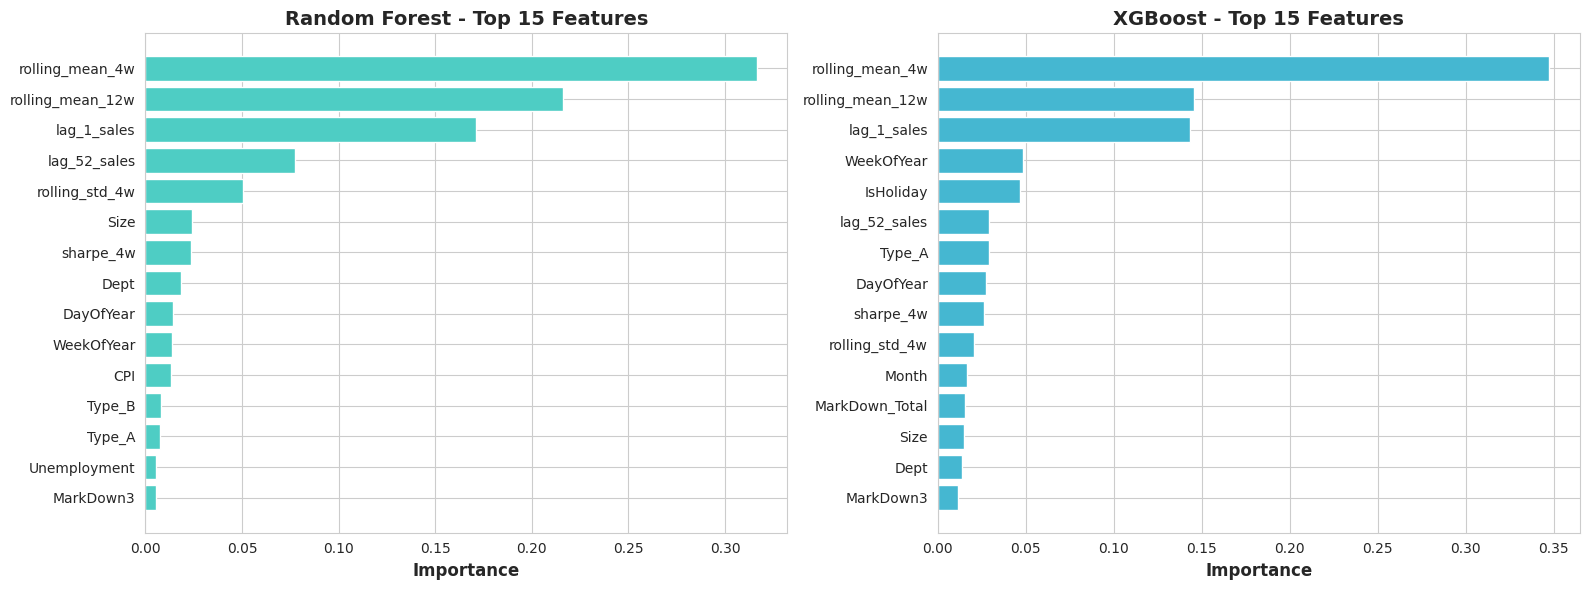

In [ ]:
#Feature importance
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

#Random Forest Feature Importance
rf_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False).head(15)

ax1 = axes[0]
ax1.barh(rf_importance['Feature'], rf_importance['Importance'], color='#4ECDC4')
ax1.set_xlabel('Importance', fontsize=12, fontweight='bold')
ax1.set_title('Random Forest - Top 15 Features', fontsize=14, fontweight='bold')
ax1.invert_yaxis()

#XGBoost Feature Importance
xgb_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False).head(15)

ax2 = axes[1]
ax2.barh(xgb_importance['Feature'], xgb_importance['Importance'], color='#45B7D1')
ax2.set_xlabel('Importance', fontsize=12, fontweight='bold')
ax2.set_title('XGBoost - Top 15 Features', fontsize=14, fontweight='bold')
ax2.invert_yaxis()

plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

BUSINESS VALUE OF THIS ANALYSIS

In [ ]:
import shap
from scipy import stats

In [ ]:
#Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

WALMART PROMOTION ROI ANALYSIS

Method- Feature Importance Analysis:

1. Sampling the test set (X_test_sample) to speed up SHAP computation

2. Creating a SHAP explainer for the trained xgb_model

3. Calculating SHAP values for each feature and each sample

4. Computing overall importance as the mean absolute SHAP value per feature, then sort descending

In [ ]:
# xgb_model, X_train, X_test, y_train, y_test, train_df

#Sample data for faster SHAP computation (using 5000 samples)
sample_size = min(5000, len(X_test))
X_test_sample = X_test.sample(n=sample_size, random_state=42)
y_test_sample = y_test.loc[X_test_sample.index]

We use SHAP for this kind of sales and markdown analysis because SHAP assigns a contribution value to each feature for every prediction, showing exactly how each markdown, trend, or seasonal feature pushes predicted sales up or down. Unlike standard feature importance from tree models, SHAP gives direction and magnitude per prediction.

Also, by using SHAP values for markdown columns, we can estimate the sales impact of each promotion type. This allows calculation of metrics like ROI per $ spent and correlation with sales lift, which is actionable for business decisions.

Further, we can identify best and worst performing promotions quantitatively which enables data-driven recommendations (e.g., reduce MarkDown2, invest more in MarkDown3).

In short, SHAP connects model predictions back to business actions — it tells you not just which markdowns matter, but how much they matter, which is essential for ROI-focused decisions.

In [ ]:
#CALCULATE SHAP VALUES
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test_sample)

In [ ]:
#OVERALL FEATURE IMPORTANCE
print("FEATURE IMPORTANCE ANALYSIS")

#Calculate mean absolute SHAP values
shap_importance = pd.DataFrame({
    'Feature': X_test_sample.columns,
    'SHAP_Importance': np.abs(shap_values).mean(axis=0)
}).sort_values('SHAP_Importance', ascending=False)

print("\nTop 15 Most Important Features:")
print(shap_importance.head(15).to_string(index=False))

FEATURE IMPORTANCE ANALYSIS

Top 15 Most Important Features:
         Feature  SHAP_Importance
 rolling_mean_4w      9829.080078
     lag_1_sales      2613.270508
rolling_mean_12w      1930.082031
       sharpe_4w       713.326721
      WeekOfYear       672.691711
  rolling_std_4w       637.862427
    lag_52_sales       617.239136
       DayOfYear       571.664429
            Dept       567.142029
            Size       325.176239
           Month       253.925446
             CPI       216.290253
     Temperature       205.925598
       IsHoliday       150.595871
       MarkDown3       146.502594


The output shows the top 15 features driving the XGBoost model’s predictions, ranked by mean absolute SHAP value.

It indicates that recent sales trends (rolling_mean_4w, lag_1_sales, rolling_mean_12w) are the most influential, followed by seasonality (WeekOfYear, DayOfYear) and other factors like risk-adjusted sales (sharpe_4w) and markdowns.

Features with higher SHAP importance have a stronger impact on the predicted sales.

In [ ]:
#MARKDOWN-SPECIFIC ANALYSIS
print("MARKDOWN IMPACT ANALYSIS")

markdown_cols = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'MarkDown_Total']
markdown_shap = shap_importance[shap_importance['Feature'].isin(markdown_cols)].copy()

print("\nMarkdown Feature Importance (SHAP):")
print(markdown_shap.to_string(index=False))

MARKDOWN IMPACT ANALYSIS

Markdown Feature Importance (SHAP):
       Feature  SHAP_Importance
     MarkDown3       146.502594
     MarkDown4       108.350861
     MarkDown2        91.005379
MarkDown_Total        42.908600
     MarkDown1        41.631447
     MarkDown5        40.674198


This output shows the relative importance of markdown features in driving the model’s predictions, based on SHAP values.

MarkDown3 has the highest impact among individual markdowns, meaning changes in this markdown influence sales more than the others.

Other markdowns (MarkDown 1, 2, 4, 5) have smaller contributions, indicating they affect predictions less strongly.

In short, the model relies more on certain markdown types than others when forecasting sales.

Next, we calculate the average sales impact, ROI, and usage statistics for each markdown type using SHAP values from the XGBoost model on test samples.

We compute ROI ratio as sales impact per $1 of markdown and correlation between markdown amount and sales lift.

In [ ]:
#PROMOTION ROI CALCULATION
print("PROMOTION ROI ESTIMATES")

roi_results = []

for md_col in ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']:
    if md_col in X_test_sample.columns:
        #Get samples where markdown was used
        md_used = X_test_sample[X_test_sample[md_col] > 0]

        if len(md_used) > 10:  #Need sufficient samples
            #Get corresponding SHAP values
            md_indices = md_used.index
            sample_indices = X_test_sample.index.get_indexer(md_indices)
            md_shap = shap_values[sample_indices, X_test_sample.columns.get_loc(md_col)]

            #Calculate metrics
            avg_markdown = md_used[md_col].mean()
            avg_shap_impact = md_shap.mean()

            #ROI = Sales Impact / Markdown Cost
            #Positive SHAP = positive impact on sales
            roi = (avg_shap_impact / avg_markdown) if avg_markdown > 0 else 0

            #Calculate correlation between markdown amount and sales impact
            correlation = np.corrcoef(md_used[md_col].values, md_shap)[0, 1]

            roi_results.append({
                'Markdown': md_col,
                'Avg_Discount_Amount': avg_markdown,
                'Avg_Sales_Impact': avg_shap_impact,
                'ROI_Ratio': roi,
                'Correlation': correlation,
                'Usage_Rate': len(md_used) / len(X_test_sample) * 100
            })

roi_df = pd.DataFrame(roi_results).sort_values('ROI_Ratio', ascending=False)

print("\n Promotion ROI Summary:")
print("\nInterpretation:")
print("- Avg_Discount_Amount: Average $ spent on this markdown type")
print("- Avg_Sales_Impact: Average $ impact on weekly sales (from SHAP)")
print("- ROI_Ratio: Sales Impact per $1 spent (higher is better)")
print("- Correlation: How strongly markdown amount correlates with sales lift")
print("- Usage_Rate: % of weeks this markdown was used\n")
print(roi_df.to_string(index=False))


PROMOTION ROI ESTIMATES

 Promotion ROI Summary:

Interpretation:
- Avg_Discount_Amount: Average $ spent on this markdown type
- Avg_Sales_Impact: Average $ impact on weekly sales (from SHAP)
- ROI_Ratio: Sales Impact per $1 spent (higher is better)
- Correlation: How strongly markdown amount correlates with sales lift
- Usage_Rate: % of weeks this markdown was used

 Markdown  Avg_Discount_Amount  Avg_Sales_Impact  ROI_Ratio  Correlation  Usage_Rate
MarkDown3          1769.744153        183.493988   0.103684     0.835866       34.34
MarkDown4          3445.218625         91.037956   0.026424     0.583818       36.06
MarkDown1          7974.654112         10.091353   0.001265     0.238108       36.48
MarkDown5          4837.307566        -21.313444  -0.004406    -0.505586       36.48
MarkDown2          3786.364356       -129.235245  -0.034132    -0.423224       28.24


MarkDown3 has the highest ROI (0.104), meaning it generates the most sales impact per $ spent, with a strong positive correlation to sales (0.836). An ROI of 0.10 means that for every dollar 1 spent on MarkDown3, the model predicts an additional dollar 0.10 in sales, which is a 10% return.

MarkDown2 and MarkDown5 show negative ROI, indicating that spending on these markdowns actually decreases sales, while others like MarkDown1 and 4 have small positive impacts.

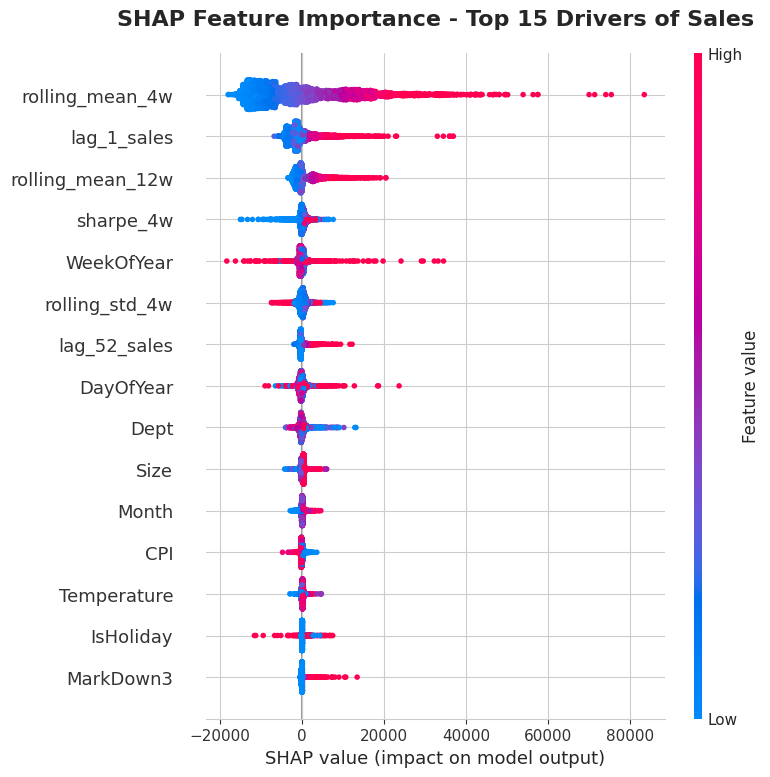

In [ ]:
#Plot 1: SHAP Summary
plt.figure(figsize=(18,6))
top_15_features = shap_importance.head(15)['Feature'].tolist()
top_15_indices = [X_test_sample.columns.get_loc(f) for f in top_15_features]

shap.summary_plot(
    shap_values[:, top_15_indices],
    X_test_sample[top_15_features],
    show=False
)
plt.title('SHAP Feature Importance - Top 15 Drivers of Sales', fontsize=16, fontweight='bold', pad=20)
plt.show()

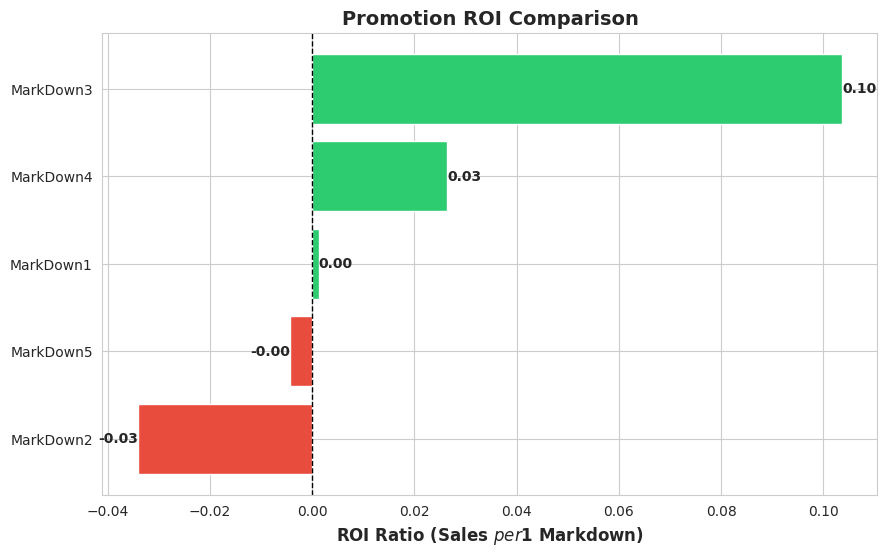

In [ ]:
#Plot 2: ROI Comparison
plt.figure(figsize=(10,6))
colors = ['#2ecc71' if x > 0 else '#e74c3c' for x in roi_df['ROI_Ratio']]
bars = plt.barh(roi_df['Markdown'], roi_df['ROI_Ratio'], color=colors)
plt.xlabel('ROI Ratio (Sales $ per $1 Markdown)', fontsize=12, fontweight='bold')
plt.title('Promotion ROI Comparison', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.gca().invert_yaxis()
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, f'{width:.2f}', ha='left' if width>0 else 'right', va='center', fontweight='bold')
plt.show()


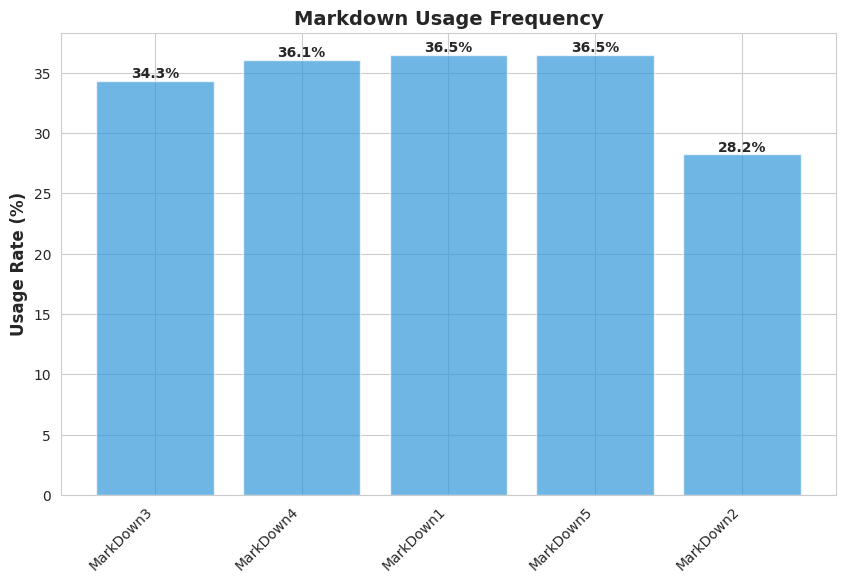

In [ ]:
#Plot 3: Usage Rate
plt.figure(figsize=(10,6))
bars = plt.bar(roi_df['Markdown'], roi_df['Usage_Rate'], color='#3498db', alpha=0.7)
plt.ylabel('Usage Rate (%)', fontsize=12, fontweight='bold')
plt.title('Markdown Usage Frequency', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')
plt.show()


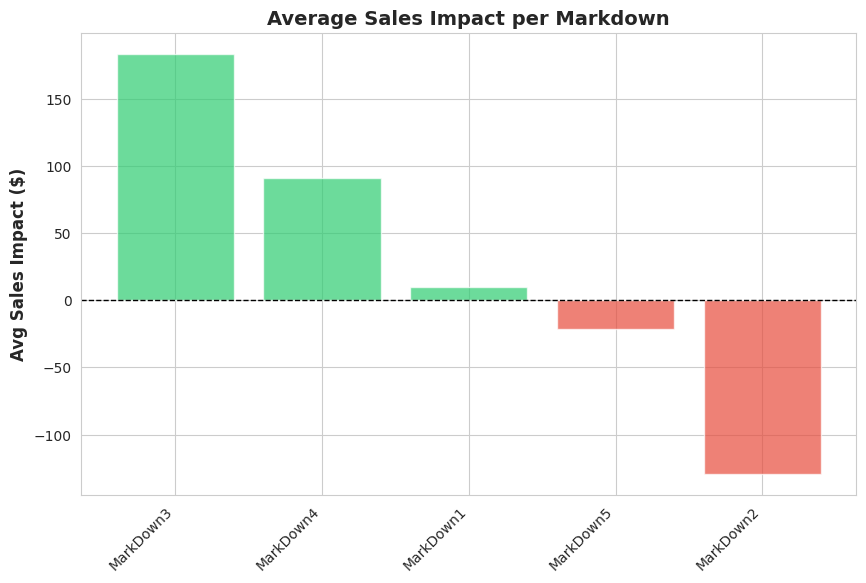

In [ ]:
#Plot 4: Average Sales Impact
plt.figure(figsize=(10,6))
colors_impact = ['#2ecc71' if x>0 else '#e74c3c' for x in roi_df['Avg_Sales_Impact']]
bars = plt.bar(roi_df['Markdown'], roi_df['Avg_Sales_Impact'], color=colors_impact, alpha=0.7)
plt.ylabel('Avg Sales Impact ($)', fontsize=12, fontweight='bold')
plt.title('Average Sales Impact per Markdown', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.show()

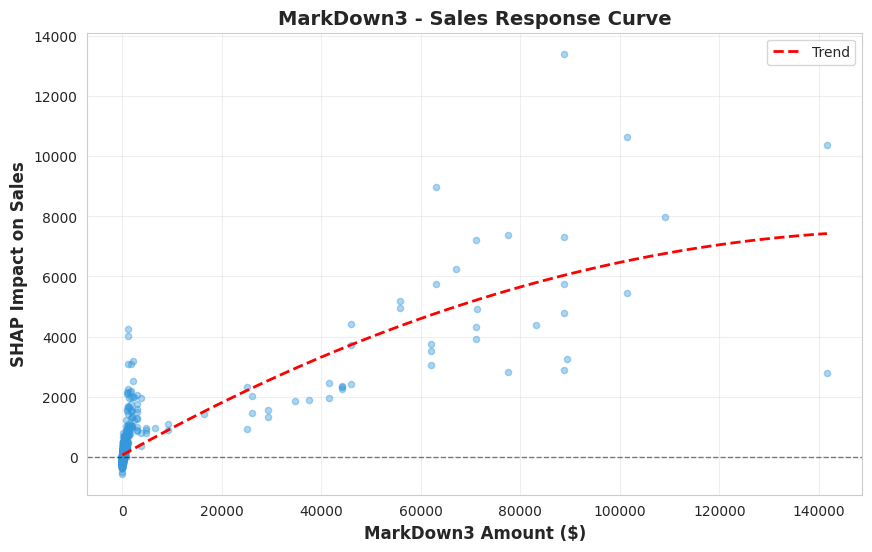

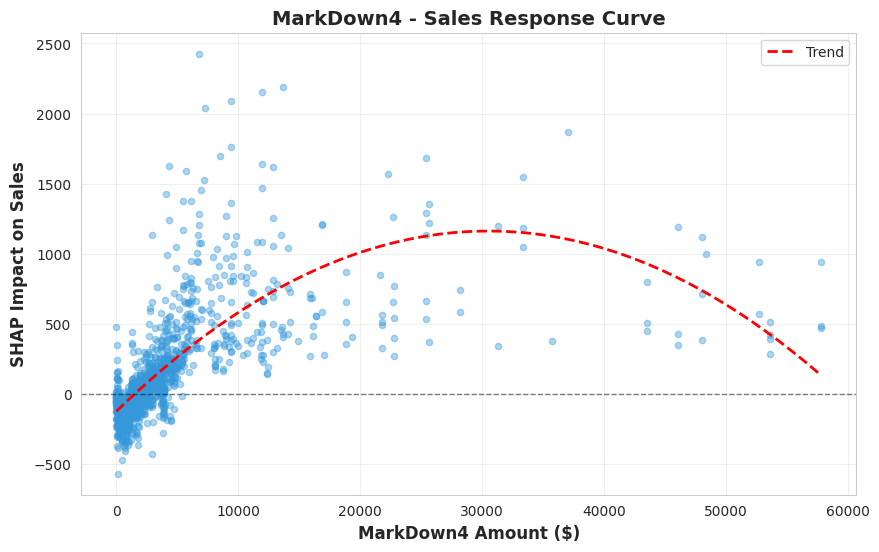

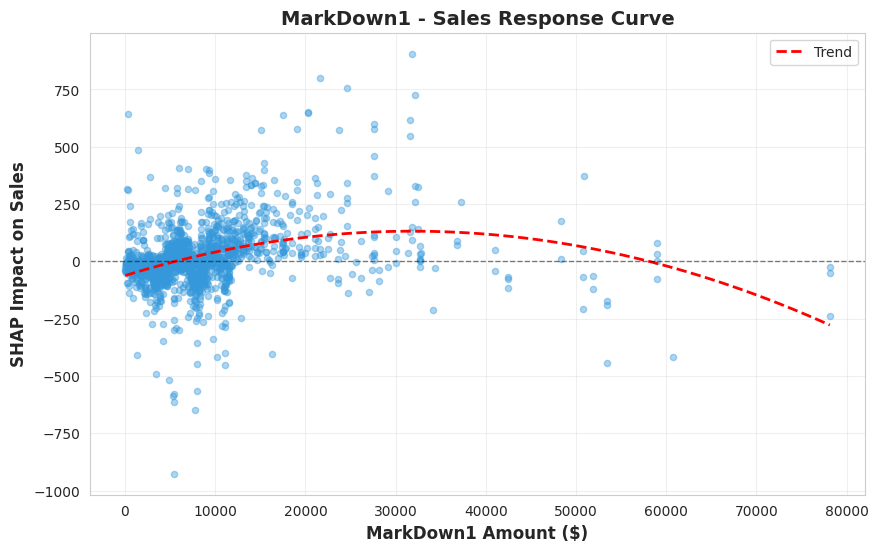

In [ ]:
#Plot 5: SHAP Dependence Plots for Top 3 Markdowns
for md in roi_df.head(3)['Markdown']:
    if md in X_test_sample.columns:
        md_idx = X_test_sample.columns.get_loc(md)
        non_zero_mask = X_test_sample[md] > 0
        x_vals = X_test_sample[md][non_zero_mask].values
        y_vals = shap_values[non_zero_mask, md_idx]

        if len(x_vals) > 0:
            plt.figure(figsize=(10,6))
            plt.scatter(x_vals, y_vals, alpha=0.4, s=20, color='#3498db')

            # Trend line
            if len(x_vals) > 10:
                z = np.polyfit(x_vals, y_vals, 2)
                p = np.poly1d(z)
                x_trend = np.linspace(x_vals.min(), x_vals.max(), 100)
                plt.plot(x_trend, p(x_trend), "r--", linewidth=2, label='Trend')

            plt.xlabel(f'{md} Amount ($)', fontsize=12, fontweight='bold')
            plt.ylabel('SHAP Impact on Sales', fontsize=12, fontweight='bold')
            plt.title(f'{md} - Sales Response Curve', fontsize=14, fontweight='bold')
            plt.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
            plt.grid(True, alpha=0.3)
            if len(x_vals) > 10:
                plt.legend()
            plt.show()


In [ ]:
#BUSINESS RECOMMENDATIONS
print("BUSINESS RECOMMENDATIONS")

#Recommendation 1: Best performers
top_2 = roi_df.head(2)
print(f"1. INCREASE INVESTMENT in {', '.join(top_2['Markdown'].tolist())}")
print(f"   These show the highest ROI ({top_2['ROI_Ratio'].values[0]:.2f} and {top_2['ROI_Ratio'].values[1]:.2f})")
print(f"   Consider expanding usage beyond current {top_2['Usage_Rate'].values[0]:.1f}% rate\n")

#Recommendation 2: Poor performers
negative_roi = roi_df[roi_df['ROI_Ratio'] < 0]
if len(negative_roi) > 0:
    print(f"2. REDUCE/ELIMINATE: {', '.join(negative_roi['Markdown'].tolist())}")
    print(f"   These have negative ROI - they cost more than they generate")
    print(f"   Potential annual savings: Significant\n")

#Recommendation 3: Optimization opportunity
print(f"3. OPTIMIZE MARKDOWN AMOUNTS:")
print(f"   Use the response curves above to identify optimal discount levels")
print(f"   Look for diminishing returns (flattening curves) = over-discounting\n")

#Recommendation 4: Seasonal/Department specific
print(f"4. NEXT STEP: Segment analysis by:")
print(f"   - Store Type (A vs B)")
print(f"   - Department categories")
print(f"   - Holiday vs Non-holiday periods")
print(f"   ROI may vary significantly across these segments\n")

BUSINESS RECOMMENDATIONS
1. INCREASE INVESTMENT in MarkDown3, MarkDown4
   These show the highest ROI (0.10 and 0.03)
   Consider expanding usage beyond current 34.3% rate

2. REDUCE/ELIMINATE: MarkDown5, MarkDown2
   These have negative ROI - they cost more than they generate
   Potential annual savings: Significant

3. OPTIMIZE MARKDOWN AMOUNTS:
   Use the response curves above to identify optimal discount levels
   Look for diminishing returns (flattening curves) = over-discounting

4. NEXT STEP: Segment analysis by:
   - Store Type (A vs B)
   - Department categories
   - Holiday vs Non-holiday periods
   ROI may vary significantly across these segments



WALMART SEGMENTED PROMOTION ROI ANALYSIS

---



In [ ]:
#PREPARE DATA WITH SEGMENTS

#Sample data for SHAP computation
sample_size = min(5000, len(X_test))
X_test_sample = X_test.sample(n=sample_size, random_state=42)
y_test_sample = y_test.loc[X_test_sample.index]

#Create full test dataset with metadata
test_indices = X_test.index
test_data = train_df.loc[test_indices].copy()
test_data['Predicted_Sales'] = xgb_model.predict(X_test)
test_data['Actual_Sales'] = y_test

#Add Store Type (A or B)
test_data['Store_Type'] = test_data[['Type_A', 'Type_B']].idxmax(axis=1).str.replace('Type_', '')

#Create Holiday flag
test_data['Period_Type'] = test_data['IsHoliday'].map({True: 'Holiday', False: 'Regular'})

#Create sample version
test_data_sample = test_data.loc[X_test_sample.index]

print("Segments created:")
print(f"   Store Types: {sorted(test_data['Store_Type'].unique())}")
print(f"   Period Types: {sorted(test_data['Period_Type'].unique())}")
print(f"   Sample size for SHAP: {len(test_data_sample):,} records\n")


Segments created:
   Store Types: ['A', 'B']
   Period Types: ['Holiday', 'Regular']
   Sample size for SHAP: 5,000 records



In [ ]:
#CALCULATE SHAP VALUES

explainer = shap.TreeExplainer(xgb_model)
shap_values_sample = explainer.shap_values(X_test_sample)

Defining a function calculate_segment_roi that computes ROI metrics for each markdown within a specific segment (store type or period), using SHAP values to estimate sales impact.

In [ ]:
#ROI CALCULATION FUNCTION
def calculate_segment_roi(data, shap_vals, X_data, segment_col, segment_value):
    """Calculate ROI metrics for a specific segment"""

    #Filter to segment
    segment_mask = data[segment_col] == segment_value
    segment_data = data[segment_mask]
    segment_X = X_data[segment_mask]
    segment_shap = shap_vals[segment_mask]

    if len(segment_data) < 30:  #Need minimum samples
        return None

    roi_results = []
    markdown_cols = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']

    for md_col in markdown_cols:
        if md_col not in segment_X.columns:
            continue

        #Get records where this markdown was used
        md_mask = segment_X[md_col] > 0

        if md_mask.sum() >= 10:  #Need minimum usage
            md_used = segment_X[md_mask]
            md_idx = segment_X.columns.get_loc(md_col)
            md_shap = segment_shap[md_mask, md_idx]

            #Calculate metrics
            avg_markdown = md_used[md_col].mean()
            avg_sales_impact = md_shap.mean()
            median_impact = np.median(md_shap)

            #ROI = Sales Impact per Dollar Spent
            roi = (avg_sales_impact / avg_markdown) if avg_markdown > 0 else 0

            roi_results.append({
                'Segment': segment_value,
                'Markdown': md_col,
                'ROI': roi,
                'Avg_Discount_$': avg_markdown,
                'Avg_Sales_Impact_$': avg_sales_impact,
                'Median_Impact_$': median_impact,
                'Usage_Count': md_mask.sum(),
                'Usage_Rate_%': (md_mask.sum() / len(segment_X)) * 100
            })

    return pd.DataFrame(roi_results) if roi_results else None

Applying the above function to Store Type segments (A vs B)

In [ ]:
#STORE TYPE ANALYSIS
print("ANALYSIS 1: STORE TYPE (A vs B)")

store_results = []
for store_type in sorted(test_data_sample['Store_Type'].unique()):
    result = calculate_segment_roi(
        test_data_sample, shap_values_sample, X_test_sample,
        'Store_Type', store_type
    )
    if result is not None:
        store_results.append(result)

if store_results:
    store_df = pd.concat(store_results, ignore_index=True)

    #Create pivot table
    pivot_store = store_df.pivot(index='Markdown', columns='Segment', values='ROI')

    print("\n ROI by Store Type (Sales $ per $1 Markdown):\n")
    print(pivot_store.round(2))

    print("\n Best Performing Markdown per Store Type:")
    for store_type in pivot_store.columns:
        best_md = pivot_store[store_type].idxmax()
        best_roi = pivot_store[store_type].max()
        worst_md = pivot_store[store_type].idxmin()
        worst_roi = pivot_store[store_type].min()
        print(f"\n   Store Type {store_type}:")
        print(f"      Best:  {best_md} (ROI: ${best_roi:.2f} per $1)")
        print(f"      Worst: {worst_md} (ROI: ${worst_roi:.2f} per $1)")

    #ROI difference between store types
    if len(pivot_store.columns) == 2:
        diff = pivot_store.iloc[:, 0] - pivot_store.iloc[:, 1]
        print(f"\n ROI Difference ({pivot_store.columns[0]} - {pivot_store.columns[1]}):")
        print(diff.sort_values(ascending=False).round(2))

ANALYSIS 1: STORE TYPE (A vs B)

 ROI by Store Type (Sales $ per $1 Markdown):

Segment       A     B
Markdown             
MarkDown1  0.00  0.00
MarkDown2 -0.04 -0.03
MarkDown3  0.12  0.08
MarkDown4  0.03  0.01
MarkDown5 -0.00 -0.00

 Best Performing Markdown per Store Type:

   Store Type A:
      Best:  MarkDown3 (ROI: $0.12 per $1)
      Worst: MarkDown2 (ROI: $-0.04 per $1)

   Store Type B:
      Best:  MarkDown3 (ROI: $0.08 per $1)
      Worst: MarkDown2 (ROI: $-0.03 per $1)

 ROI Difference (A - B):
Markdown
MarkDown3    0.05
MarkDown4    0.02
MarkDown1    0.00
MarkDown5   -0.00
MarkDown2   -0.01
dtype: float64


MarkDown3 is the best performing markdown in both stores, with ROI dollar 0.12 in Type A and dollar 0.08 in Type B, while MarkDown2 is the worst with negative ROI in both.

ROI differences show that Type A generally benefits more from MarkDown3 and MarkDown4 than Type B.

Other markdowns have minimal impact, suggesting store-specific promotion strategies may improve efficiency.

In [ ]:
#HOLIDAY PERIOD ANALYSIS
print("ANALYSIS 2: HOLIDAY vs REGULAR PERIODS")

holiday_results = []
for period in sorted(test_data_sample['Period_Type'].unique()):
    result = calculate_segment_roi(
        test_data_sample, shap_values_sample, X_test_sample,
        'Period_Type', period
    )
    if result is not None:
        holiday_results.append(result)

if holiday_results:
    holiday_df = pd.concat(holiday_results, ignore_index=True)

    #Create pivot
    pivot_holiday = holiday_df.pivot(index='Markdown', columns='Segment', values='ROI')

    print("\n ROI by Period Type:\n")
    print(pivot_holiday.round(2))

    #Calculate holiday boost/penalty
    if 'Holiday' in pivot_holiday.columns and 'Regular' in pivot_holiday.columns:
        holiday_effect = pd.DataFrame({
            'Markdown': pivot_holiday.index,
            'Holiday_ROI': pivot_holiday['Holiday'].values,
            'Regular_ROI': pivot_holiday['Regular'].values,
            'Holiday_Effect': (pivot_holiday['Holiday'] - pivot_holiday['Regular']).values,
            'Effect_%': ((pivot_holiday['Holiday'] - pivot_holiday['Regular']) / pivot_holiday['Regular'] * 100).values
        }).sort_values('Holiday_Effect', ascending=False)

        print("\n Holiday Effect Analysis:")
        print(holiday_effect.round(2).to_string(index=False))

        print("\n Key Insights:")
        # Best for holidays
        best_holiday = holiday_effect.iloc[0]
        print(f"   Best Holiday Boost: {best_holiday['Markdown']}")
        print(f"      Regular ROI: ${best_holiday['Regular_ROI']:.2f}")
        print(f"      Holiday ROI: ${best_holiday['Holiday_ROI']:.2f}")
        print(f"      Improvement: +{best_holiday['Effect_%']:.1f}%")

        # Worst for holidays
        worst_holiday = holiday_effect.iloc[-1]
        print(f"\n    Worst Holiday Performance: {worst_holiday['Markdown']}")
        print(f"      Regular ROI: ${worst_holiday['Regular_ROI']:.2f}")
        print(f"      Holiday ROI: ${worst_holiday['Holiday_ROI']:.2f}")
        print(f"      Change: {worst_holiday['Effect_%']:.1f}%")


ANALYSIS 2: HOLIDAY vs REGULAR PERIODS

 ROI by Period Type:

Segment    Holiday  Regular
Markdown                   
MarkDown1     0.01     0.00
MarkDown2    -0.01    -0.05
MarkDown3     0.07     0.32
MarkDown4     0.04     0.03
MarkDown5     0.01    -0.01

 Holiday Effect Analysis:
 Markdown  Holiday_ROI  Regular_ROI  Holiday_Effect  Effect_%
MarkDown2        -0.01        -0.05            0.04    -74.55
MarkDown4         0.04         0.03            0.02     65.82
MarkDown5         0.01        -0.01            0.02   -282.47
MarkDown1         0.01         0.00            0.00    461.19
MarkDown3         0.07         0.32           -0.25    -78.00

 Key Insights:
   Best Holiday Boost: MarkDown2
      Regular ROI: $-0.05
      Holiday ROI: $-0.01
      Improvement: +-74.6%

    Worst Holiday Performance: MarkDown3
      Regular ROI: $0.32
      Holiday ROI: $0.07
      Change: -78.0%


Best Holiday Boost: MarkDown2 – its ROI improves from -0.05 (regular) to -0.01 (holiday), a 74.6% improvement, indicating it performs less badly during holidays.

Worst Holiday Performance: MarkDown3 – ROI drops sharply from 0.32 (regular) to 0.07 (holiday), a 78% decline, suggesting this markdown is far less effective during holiday periods.

MarkDown4 and MarkDown5 show modest positive changes, while MarkDown1 improves slightly but its absolute impact is small.

Key takeaway: Holiday periods change the effectiveness of markdowns, so promotions should be adjusted seasonally to maximize ROI.

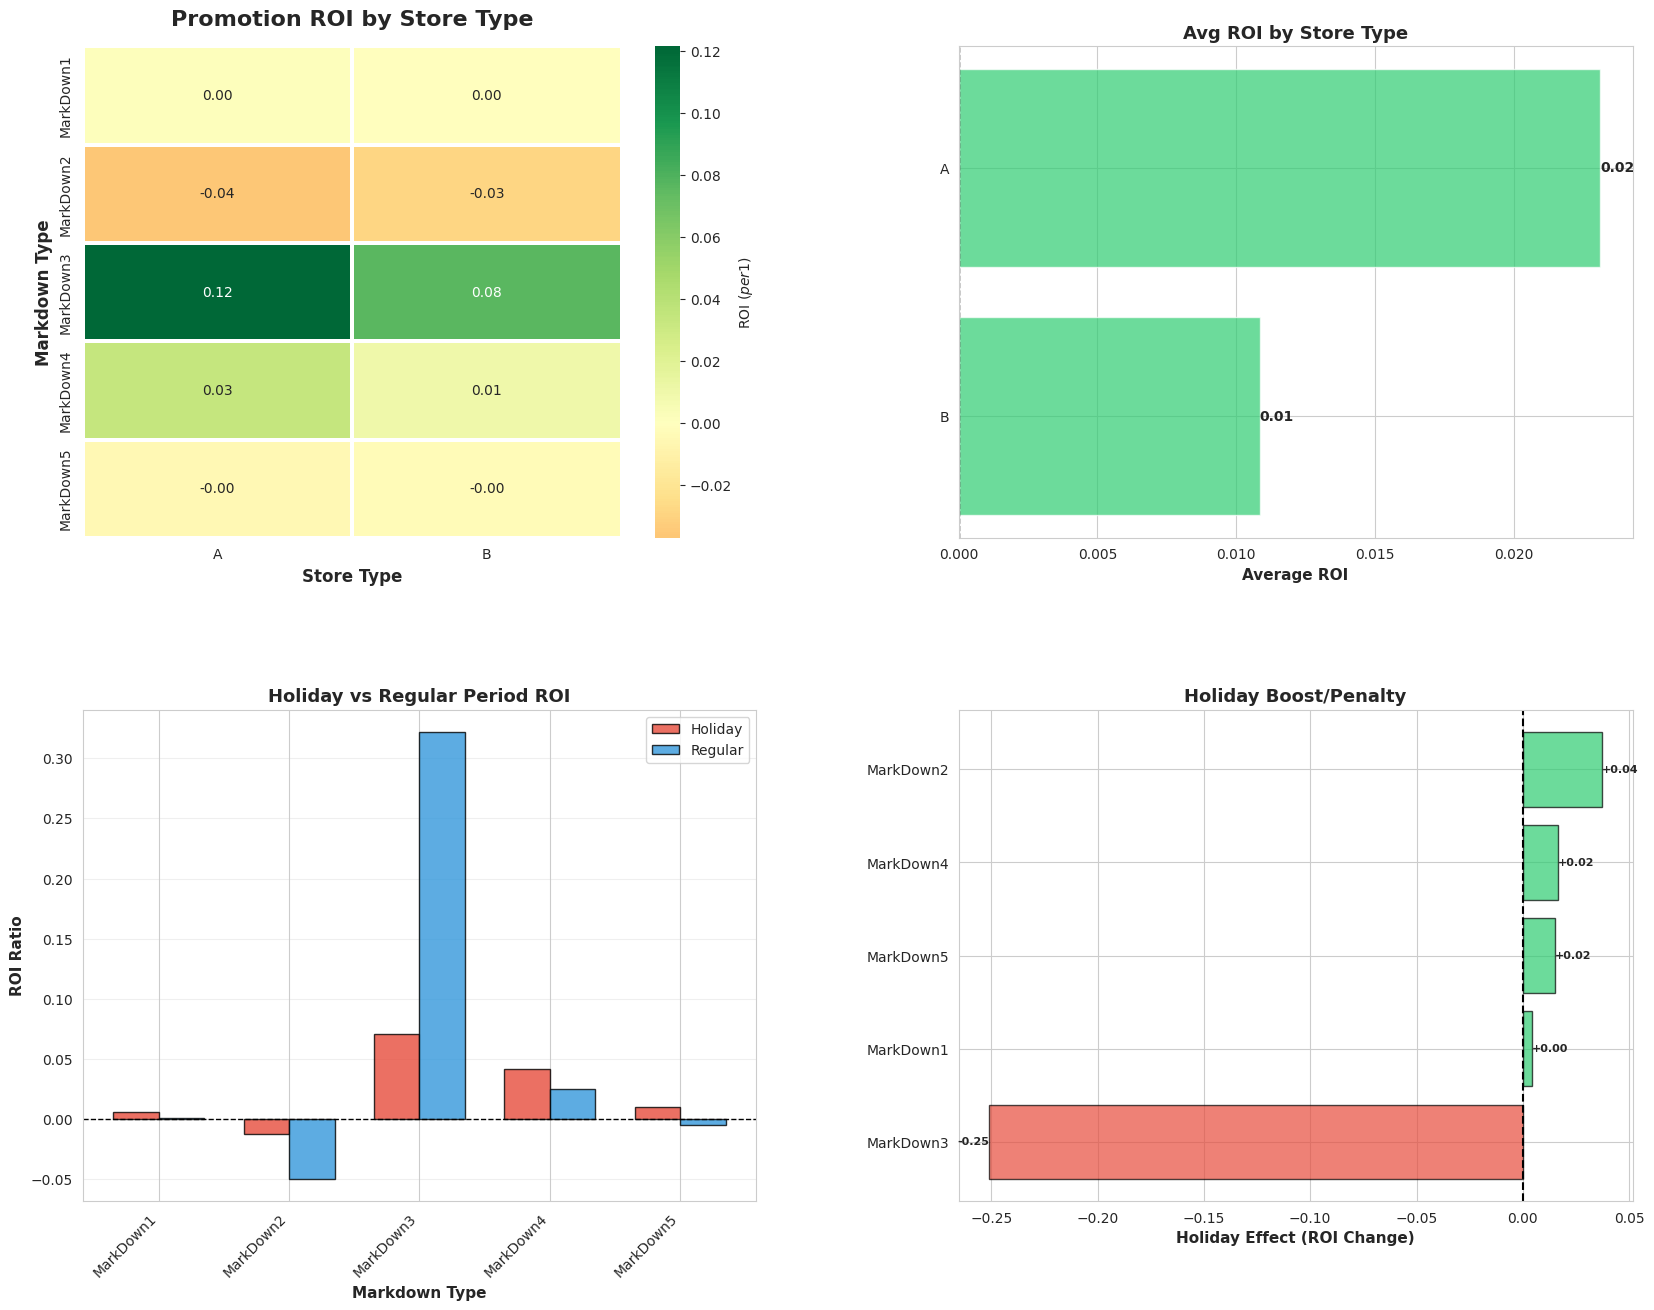

In [ ]:
#VISUALIZATIONS

fig = plt.figure(figsize=(20, 15))
gs = fig.add_gridspec(2, 2, hspace=0.35, wspace=0.3)

#Plot 1: Store Type Heatmap
if store_results:
    ax1 = fig.add_subplot(gs[0, 0])
    sns.heatmap(pivot_store, annot=True, fmt='.2f', cmap='RdYlGn', center=0,
                cbar_kws={'label': 'ROI ($ per $1)'}, ax=ax1, linewidths=1.5)
    ax1.set_title('Promotion ROI by Store Type', fontsize=16, fontweight='bold', pad=15)
    ax1.set_xlabel('Store Type', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Markdown Type', fontsize=12, fontweight='bold')

#Plot 2: Store Type Comparison
if store_results:
    ax2 = fig.add_subplot(gs[0, 1])
    store_avg = store_df.groupby('Segment')['ROI'].mean().sort_values()
    colors = ['#e74c3c' if x < 0 else '#2ecc71' for x in store_avg.values]
    bars = ax2.barh(store_avg.index, store_avg.values, color=colors, alpha=0.7)
    ax2.set_xlabel('Average ROI', fontsize=11, fontweight='bold')
    ax2.set_title('Avg ROI by Store Type', fontsize=13, fontweight='bold')
    ax2.axvline(x=0, color='black', linestyle='--', linewidth=1)
    for bar in bars:
        width = bar.get_width()
        ax2.text(width, bar.get_y() + bar.get_height()/2,
                f'{width:.2f}', ha='left' if width > 0 else 'right',
                va='center', fontweight='bold')


#Plot 3: Holiday vs Regular Comparison
if holiday_results and 'Holiday' in pivot_holiday.columns and 'Regular' in pivot_holiday.columns:
    ax4 = fig.add_subplot(gs[1, 0])
    x = np.arange(len(pivot_holiday.index))
    width = 0.35
    bars1 = ax4.bar(x - width/2, pivot_holiday['Holiday'], width,
                    label='Holiday', color='#e74c3c', alpha=0.8, edgecolor='black')
    bars2 = ax4.bar(x + width/2, pivot_holiday['Regular'], width,
                    label='Regular', color='#3498db', alpha=0.8, edgecolor='black')
    ax4.set_xlabel('Markdown Type', fontsize=11, fontweight='bold')
    ax4.set_ylabel('ROI Ratio', fontsize=11, fontweight='bold')
    ax4.set_title('Holiday vs Regular Period ROI', fontsize=13, fontweight='bold')
    ax4.set_xticks(x)
    ax4.set_xticklabels(pivot_holiday.index, rotation=45, ha='right')
    ax4.legend(fontsize=10)
    ax4.axhline(y=0, color='black', linestyle='--', linewidth=1)
    ax4.grid(True, alpha=0.3, axis='y')


#Plot 4: Holiday Effect Waterfall
if holiday_results and 'Holiday' in pivot_holiday.columns and 'Regular' in pivot_holiday.columns:
    ax6 = fig.add_subplot(gs[1, 1])
    holiday_diff = (pivot_holiday['Holiday'] - pivot_holiday['Regular']).sort_values(ascending=False)
    colors = ['#2ecc71' if x > 0 else '#e74c3c' for x in holiday_diff.values]
    bars = ax6.barh(range(len(holiday_diff)), holiday_diff.values, color=colors, alpha=0.7, edgecolor='black')
    ax6.set_yticks(range(len(holiday_diff)))
    ax6.set_yticklabels(holiday_diff.index, fontsize=10)
    ax6.set_xlabel('Holiday Effect (ROI Change)', fontsize=11, fontweight='bold')
    ax6.set_title('Holiday Boost/Penalty', fontsize=13, fontweight='bold')
    ax6.axvline(x=0, color='black', linestyle='--', linewidth=1.5)
    ax6.invert_yaxis()
    for bar in bars:
        width = bar.get_width()
        ax6.text(width, bar.get_y() + bar.get_height()/2,
                f'{width:+.2f}', ha='left' if width > 0 else 'right',
                va='center', fontweight='bold', fontsize=8)

plt.show()

In [ ]:
#RECOMMENDATIONS

print("RECOMMENDATIONS")

print("\n STORE TYPE STRATEGY:")
if store_results:
    for store_type in sorted(test_data['Store_Type'].unique()):
        store_data = store_df[store_df['Segment'] == store_type]
        if len(store_data) > 0:
            best_2 = store_data.nlargest(2, 'ROI')
            worst = store_data.nsmallest(1, 'ROI')

            print(f"\n   Store Type {store_type}:")
            print(f"   INCREASE: {', '.join(best_2['Markdown'].tolist())}")
            print(f"      ROI: ${best_2['ROI'].values[0]:.2f} and ${best_2['ROI'].values[1]:.2f} per dollar")
            if worst['ROI'].values[0] < 0:
                print(f"    ELIMINATE: {worst['Markdown'].values[0]} (Negative ROI: ${worst['ROI'].values[0]:.2f})")
            else:
                print(f"     MINIMIZE: {worst['Markdown'].values[0]} (Low ROI: ${worst['ROI'].values[0]:.2f})")

print("\n\n HOLIDAY CALENDAR STRATEGY:")
if holiday_results and 'Holiday' in pivot_holiday.columns and 'Regular' in pivot_holiday.columns:
    holiday_boost = (pivot_holiday['Holiday'] - pivot_holiday['Regular']).sort_values(ascending=False)

    print(f"   INCREASE DURING HOLIDAYS:")
    for md in holiday_boost.head(2).index:
        boost = holiday_boost[md]
        holiday_roi = pivot_holiday.loc[md, 'Holiday']
        if boost > 0:
            print(f"      {md}: +${boost:.2f} ROI boost (Holiday ROI: ${holiday_roi:.2f})")

    print(f"\n    REDUCE DURING HOLIDAYS:")
    for md in holiday_boost.tail(2).index:
        drop = holiday_boost[md]
        holiday_roi = pivot_holiday.loc[md, 'Holiday']
        if drop < 0:
            print(f"      {md}: ${drop:.2f} ROI drop (Holiday ROI: ${holiday_roi:.2f})")


RECOMMENDATIONS

 STORE TYPE STRATEGY:

   Store Type A:
   INCREASE: MarkDown3, MarkDown4
      ROI: $0.12 and $0.03 per dollar
    ELIMINATE: MarkDown2 (Negative ROI: $-0.04)

   Store Type B:
   INCREASE: MarkDown3, MarkDown4
      ROI: $0.08 and $0.01 per dollar
    ELIMINATE: MarkDown2 (Negative ROI: $-0.03)


 HOLIDAY CALENDAR STRATEGY:
   INCREASE DURING HOLIDAYS:
      MarkDown2: +$0.04 ROI boost (Holiday ROI: $-0.01)
      MarkDown4: +$0.02 ROI boost (Holiday ROI: $0.04)

    REDUCE DURING HOLIDAYS:
      MarkDown3: $-0.25 ROI drop (Holiday ROI: $0.07)


The above strategy tailors markdown promotions by store type and holiday periods to maximize ROI and avoid negative-impact promotions.

MACROECONOMIC FACTORS - QUICK IMPACT ANALYSIS

In [ ]:
from sklearn.inspection import partial_dependence, PartialDependenceDisplay

In [ ]:
#IDENTIFY & RANK ECONOMIC FEATURES

economic_features = ['Fuel_Price', 'CPI', 'Unemployment', 'Temperature']
available_econ = [f for f in economic_features if f in X_test.columns]

#Get XGBoost feature importance
feature_importance = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

#Filter to economic features
econ_importance = feature_importance[feature_importance['Feature'].isin(available_econ)].copy()
econ_importance['Rank'] = range(1, len(econ_importance) + 1)

print("\n Economic Features Ranked by Importance:\n")
print(econ_importance.to_string(index=False))

#Get descriptive statistics
print("\n Economic Feature Statistics:")
print(X_test[available_econ].describe().round(2))




 Economic Features Ranked by Importance:

     Feature  Importance  Rank
Unemployment    0.005112     1
 Temperature    0.004895     2
  Fuel_Price    0.004725     3
         CPI    0.004694     4

 Economic Feature Statistics:
       Fuel_Price      CPI  Unemployment  Temperature
count     8580.00  8580.00       8580.00      8580.00
mean         3.33   178.56          7.59        60.59
std          0.45    40.20          1.67        18.64
min          2.51   126.06          3.88        -2.06
25%          2.89   131.15          6.53        47.30
50%          3.39   192.83          7.37        62.61
75%          3.70   215.14          8.18        75.44
max          4.47   227.23         14.31        99.22


Unemployment, Temperature, Fuel Price, and CPI all have very low XGBoost importance scores, meaning macroeconomic factors contribute only a small share of Walmart sales prediction power in this model.
Their statistical ranges look normal and realistic, so including them in the analysis makes sense — but they are secondary drivers compared to store, seasonal, and promotional features.

Walmart sales are historically driven far more by promotions, store characteristics, and holidays than by macroeconomic shifts, so it’s expected that these economic features rank low in importance.

In [ ]:
#CORRELATION ANALYSIS
print("CORRELATION WITH SALES")

correlations = []
for feat in available_econ:
    corr, p_value = stats.pearsonr(X_test[feat], y_test)
    correlations.append({
        'Feature': feat,
        'Correlation': corr,
        'Direction': '↑ Positive' if corr > 0 else '↓ Negative',
        'Strength': 'Strong' if abs(corr) > 0.5 else 'Moderate' if abs(corr) > 0.3 else 'Weak'
    })

corr_df = pd.DataFrame(correlations).sort_values('Correlation', key=abs, ascending=False)
print("\n")
print(corr_df.round(3).to_string(index=False))


CORRELATION WITH SALES


     Feature  Correlation  Direction Strength
         CPI       -0.184 ↓ Negative     Weak
Unemployment        0.062 ↑ Positive     Weak
 Temperature        0.046 ↑ Positive     Weak
  Fuel_Price        0.042 ↑ Positive     Weak


All economic features show only weak correlations with sales (< 0.2), meaning they explain very little of Walmart’s sales variation.
This is expected — sales respond much more to promotions, holidays, and store factors than to slow-moving macroeconomic variables.

In [ ]:
#MANUAL PARTIAL DEPENDENCE
def compute_pdp(model, X, feature, grid_points=30):
    """
    Computes partial dependence manually for any model.
    """
    grid = np.linspace(X[feature].min(), X[feature].max(), grid_points)
    avg_pred = []

    X_copy = X.copy()

    for val in grid:
        X_copy[feature] = val
        avg_pred.append(model.predict(X_copy).mean())

    return grid, np.array(avg_pred)

#CAUSAL IMPACT + ELASTICITY

#Use sample for speed
sample_size = min(5000, len(X_test))
X_sample = X_test.sample(n=sample_size, random_state=42)

pd_results = {}
elasticities = []

for feat in available_econ:

    #compute PDP manually
    values, avg_predictions = compute_pdp(
        model=xgb_model,
        X=X_sample,
        feature=feat,
        grid_points=30
    )

    pd_results[feat] = (values, avg_predictions)

    #elasticity calculation
    mid_idx = len(values) // 2

    feature_pct_change = ((values[-1] - values[0]) / values[mid_idx]) * 100 if values[mid_idx] != 0 else 0
    sales_pct_change = ((avg_predictions[-1] - avg_predictions[0]) / avg_predictions[mid_idx]) * 100 if avg_predictions[mid_idx] != 0 else 0

    elasticity = sales_pct_change / feature_pct_change if feature_pct_change != 0 else 0

    elasticities.append({
        'Feature': feat,
        'Elasticity': elasticity,
        'Min_Sales': avg_predictions.min(),
        'Max_Sales': avg_predictions.max(),
        'Sales_Range': avg_predictions.max() - avg_predictions.min(),
        'Direction': 'Positive ↑' if avg_predictions[-1] > avg_predictions[0] else 'Negative ↓'
    })

elasticity_df = pd.DataFrame(elasticities).sort_values('Sales_Range', ascending=False)

#OUTPUT

print("Causal Impact Summary:\n")
print(elasticity_df.round(3).to_string(index=False))

Causal Impact Summary:

     Feature  Elasticity    Min_Sales    Max_Sales  Sales_Range  Direction
 Temperature       0.009 24789.683594 25870.722656  1081.038940 Positive ↑
         CPI      -0.065 25109.378906 26145.343750  1035.964966 Negative ↓
Unemployment      -0.005 25222.992188 25851.001953   628.010010 Negative ↓
  Fuel_Price       0.023 25042.076172 25533.923828   491.847992 Positive ↑


Economic variables have very small elasticities (all close to zero), meaning a 1% change in CPI, unemployment, fuel price, or temperature barely moves sales (< 0.07%).
This again confirms that Walmart store sales are driven far more by promotions, holidays, and store attributes than by macroeconomic shifts.

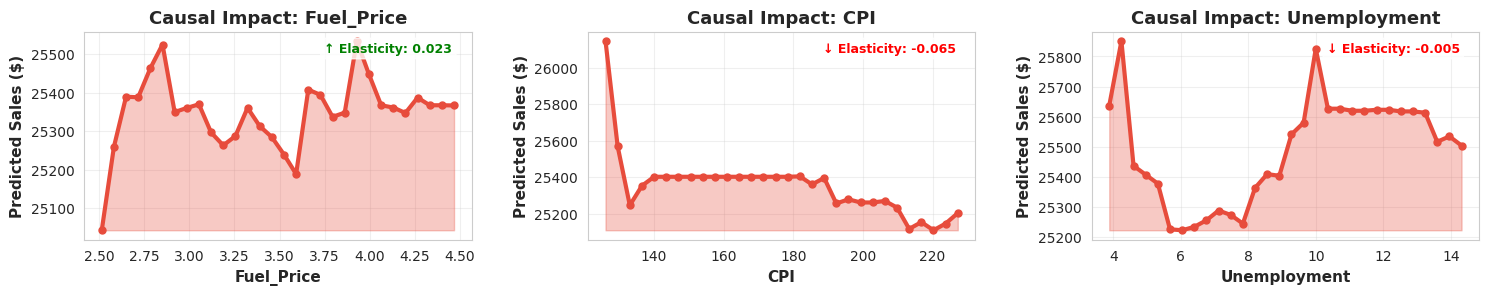

In [ ]:
#VISUALIZATIONS

fig = plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.3)


#Plot 1-3: Partial Dependence Curves
for idx, feat in enumerate(available_econ[:3]):
    ax = fig.add_subplot(gs[1, idx])

    # --- FIX: unpack tuple ---
    values, avg_predictions = pd_results[feat]

    ax.plot(values, avg_predictions, linewidth=3, color='#e74c3c', marker='o', markersize=5)
    ax.fill_between(values, avg_predictions.min(), avg_predictions, alpha=0.3, color='#e74c3c')
    ax.set_xlabel(feat, fontsize=11, fontweight='bold')
    ax.set_ylabel('Predicted Sales ($)', fontsize=11, fontweight='bold')
    ax.set_title(f'Causal Impact: {feat}', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.ticklabel_format(style='plain', axis='y')

    # Add elasticity annotation
    elast = elasticity_df[elasticity_df['Feature'] == feat]['Elasticity'].values[0]
    direction = '↑' if avg_predictions[-1] > avg_predictions[0] else '↓'
    color = 'green' if avg_predictions[-1] > avg_predictions[0] else 'red'

    ax.text(
        0.95, 0.95,
        f'{direction} Elasticity: {elast:.3f}',
        transform=ax.transAxes, fontsize=9, fontweight='bold',
        color=color, ha='right', va='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
    )


plt.show()

CASH FLOW STABILITY ANALYSIS

In [ ]:
#PREPARE DATA WITH PREDICTIONS

#Get predictions for all test data
test_data = train_df.loc[X_test.index].copy()
test_data['Predicted_Sales'] = xgb_model.predict(X_test)
test_data['Actual_Sales'] = y_test
test_data['Prediction_Error'] = test_data['Actual_Sales'] - test_data['Predicted_Sales']
test_data['Store_Type'] = test_data[['Type_A', 'Type_B']].idxmax(axis=1).str.replace('Type_', '')

print(f"   Stores: {test_data['Store'].nunique()}")
print(f"   Departments: {test_data['Dept'].nunique()}")
print(f"   Time periods: {len(test_data):,} store-dept-week combinations\n")

   Stores: 20
   Departments: 15
   Time periods: 8,580 store-dept-week combinations



Coefficient of Variation (CV) = Std Dev / Mean

CV < 0.3  = Stable (predictable cash flow)

CV 0.3-0.6 = Moderate volatility

CV > 0.6  = Volatile (unpredictable cash flow)

In [ ]:
#ANALYSIS #1: SALES VOLATILITY

#Store-level volatility
store_volatility = test_data.groupby('Store').agg({
    'Actual_Sales': ['mean', 'std', 'min', 'max', 'count']
}).round(2)

store_volatility.columns = ['Avg_Sales', 'Std_Dev', 'Min_Sales', 'Max_Sales', 'Weeks']
store_volatility['CV'] = (store_volatility['Std_Dev'] / store_volatility['Avg_Sales']).round(3)
store_volatility['Range'] = store_volatility['Max_Sales'] - store_volatility['Min_Sales']
store_volatility['Range_Pct'] = (store_volatility['Range'] / store_volatility['Avg_Sales'] * 100).round(1)

#Add store type
store_types = test_data.groupby('Store')['Store_Type'].first()
store_volatility = store_volatility.join(store_types)

#Classify stability
def classify_stability(cv):
    if cv < 0.3:
        return 'Stable'
    elif cv < 0.6:
        return 'Moderate'
    else:
        return 'Volatile'

store_volatility['Stability_Class'] = store_volatility['CV'].apply(classify_stability)

print("Store Volatility Summary:\n")

print(f"Stability Classification:")
stability_counts = store_volatility['Stability_Class'].value_counts()
for stability, count in stability_counts.items():
    pct = count / len(store_volatility) * 100
    print(f"  {stability}: {count} stores ({pct:.1f}%)")

print("\n Top 5 Most STABLE Stores (Lowest CV):")
top_stable = store_volatility.nsmallest(5, 'CV')[['Avg_Sales', 'CV', 'Store_Type', 'Stability_Class']]
print(top_stable.to_string())

print("\n  Top 5 Most VOLATILE Stores (Highest CV):")
top_volatile = store_volatility.nlargest(5, 'CV')[['Avg_Sales', 'CV', 'Store_Type', 'Stability_Class']]
print(top_volatile.to_string())


Store Volatility Summary:

Stability Classification:
  Volatile: 12 stores (60.0%)
  Moderate: 8 stores (40.0%)

 Top 5 Most STABLE Stores (Lowest CV):
       Avg_Sales     CV Store_Type Stability_Class
Store                                             
9       13632.62  0.545          B        Moderate
6       30761.80  0.550          A        Moderate
3        8222.97  0.566          B        Moderate
8       17588.70  0.569          A        Moderate
1       26223.77  0.579          A        Moderate

  Top 5 Most VOLATILE Stores (Highest CV):
       Avg_Sales     CV Store_Type Stability_Class
Store                                             
12      25352.03  0.749          B        Volatile
13      37383.38  0.749          A        Volatile
16      13028.00  0.748          B        Volatile
14      33898.18  0.745          A        Volatile
4       40958.69  0.706          A        Volatile


Key Findings:

60% of stores are Volatile

40% are Moderate

Top 5 most stable stores: CV ~0.545–0.579 → moderate stability

Top 5 most volatile stores: CV ~0.706–0.749 → high unpredictability

Most stores have moderately unpredictable sales week-to-week, with a few very volatile stores that could pose operational risk.

Business implication:
High volatility stores: Need extra attention for staffing, inventory, and cash planning.

Stable stores: More predictable and lower operational risk.

Operational insight: Even if promotions are effective, volatility could reduce predictability of revenue.

Revenue at Risk (VaR) Interpretation:

VaR_5%: 95% confident weekly sales won't drop below this

VaR_10%: 90% confident weekly sales won't drop below this

Downside_Risk_Ratio: % below mean in worst 5% of weeks

In [ ]:
#ANALYSIS 2: REVENUE AT RISK (VaR) (Minimum Cash Flow Planning)")

#Store-level VaR
store_var = test_data.groupby('Store')['Actual_Sales'].agg([
    ('Mean', 'mean'),
    ('VaR_5%', lambda x: np.percentile(x, 5)),
    ('VaR_10%', lambda x: np.percentile(x, 10)),
    ('Median', 'median'),
    ('VaR_90%', lambda x: np.percentile(x, 90)),
    ('VaR_95%', lambda x: np.percentile(x, 95))
]).round(0)

#Calculate downside risk
store_var['Downside_5%'] = store_var['Mean'] - store_var['VaR_5%']
store_var['Downside_10%'] = store_var['Mean'] - store_var['VaR_10%']
store_var['Downside_Risk_Ratio'] = (store_var['Downside_5%'] / store_var['Mean'] * 100).round(1)

# Add store type and volatility
store_var = store_var.join(store_types)
store_var = store_var.join(store_volatility[['CV', 'Stability_Class']])

print("  Top 10 Stores with HIGHEST Downside Risk:")
high_risk = store_var.nlargest(10, 'Downside_Risk_Ratio')[
    ['Mean', 'VaR_5%', 'Downside_5%', 'Downside_Risk_Ratio', 'Store_Type', 'Stability_Class']
]
print(high_risk.to_string())

print("\n  Top 10 Stores with LOWEST Downside Risk (Most Stable):")
low_risk = store_var.nsmallest(10, 'Downside_Risk_Ratio')[
    ['Mean', 'VaR_5%', 'Downside_5%', 'Downside_Risk_Ratio', 'Store_Type', 'Stability_Class']
]
print(low_risk.to_string())

#Aggregate by store type
print("\n Risk Profile by Store Type:")
risk_by_type = store_var.groupby('Store_Type').agg({
    'Mean': 'mean',
    'Downside_Risk_Ratio': 'mean',
    'CV': 'mean'
}).round(2)
print(risk_by_type)


  Top 10 Stores with HIGHEST Downside Risk:
          Mean  VaR_5%  Downside_5%  Downside_Risk_Ratio Store_Type Stability_Class
Store                                                                              
14     33898.0  4690.0      29208.0                 86.2          A        Volatile
18     22779.0  3396.0      19383.0                 85.1          B        Volatile
4      40959.0  6229.0      34730.0                 84.8          A        Volatile
11     24933.0  3973.0      20960.0                 84.1          A        Volatile
13     37383.0  5964.0      31419.0                 84.0          A        Volatile
12     25352.0  4272.0      21080.0                 83.1          B        Volatile
20     39264.0  6620.0      32644.0                 83.1          A        Volatile
1      26224.0  4662.0      21562.0                 82.2          A        Moderate
15     14873.0  2684.0      12189.0                 82.0          B        Volatile
9      13633.0  2462.0      1117

1. Top 10 Stores – Highest Downside Risk: Stores 14, 18, 4, 11, etc., have Downside_Risk_Ratio ~82–86%, meaning in the worst 5% of weeks, sales could fall ~82–86% below the mean. Most of these stores are Volatile, highlighting high risk to cash flow. Even stores with moderate mean sales (e.g., Store 1) can have high downside risk due to variability.

2. Top 10 Stores – Lowest Downside Risk: Stores like 7, 3, 16, etc., have lower downside risk (~68–82%), making them more predictable for cash flow. Some are still classified as Volatile, which shows that low mean doesn’t always equal stability; variability matters.

3. Aggregate by Store Type: Type A: Higher mean sales ($31,144) but slightly higher downside risk (83%) and CV (0.66). Type B: Lower mean sales (18,598) but slightly lower downside risk (80%) and CV (0.64). This indicates Type A stores generate more revenue but are slightly riskier, whereas Type B stores are smaller but more predictable.

Key Takeaways:

High-risk stores (high downside ratio + volatile) need contingency cash planning.

VaR helps identify stores that could experience extremely low sales, even if average sales are high.


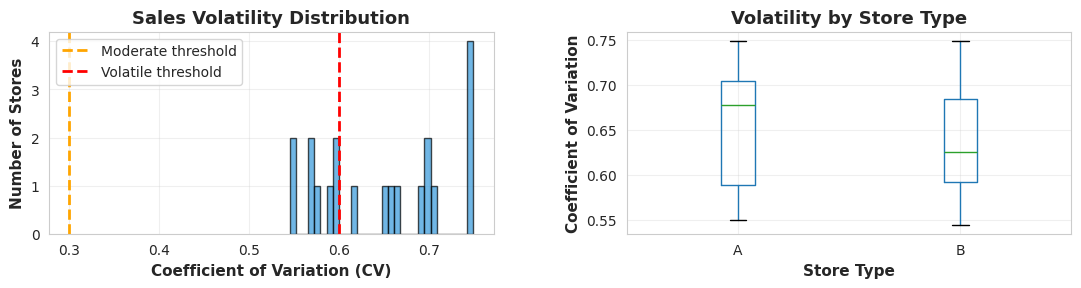

In [ ]:
#VISUALIZATIONS

fig = plt.figure(figsize=(20, 14))
gs = fig.add_gridspec(4, 3, hspace=0.4, wspace=0.3)

# Plot 1: Volatility Distribution
ax1 = fig.add_subplot(gs[0, 0])
store_volatility['CV'].hist(bins=30, ax=ax1, color='#3498db', alpha=0.7, edgecolor='black')
ax1.axvline(x=0.3, color='orange', linestyle='--', linewidth=2, label='Moderate threshold')
ax1.axvline(x=0.6, color='red', linestyle='--', linewidth=2, label='Volatile threshold')
ax1.set_xlabel('Coefficient of Variation (CV)', fontsize=11, fontweight='bold')
ax1.set_ylabel('Number of Stores', fontsize=11, fontweight='bold')
ax1.set_title('Sales Volatility Distribution', fontsize=13, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Volatility by Store Type
ax2 = fig.add_subplot(gs[0, 1])
store_volatility.boxplot(column='CV', by='Store_Type', ax=ax2)
ax2.set_xlabel('Store Type', fontsize=11, fontweight='bold')
ax2.set_ylabel('Coefficient of Variation', fontsize=11, fontweight='bold')
ax2.set_title('Volatility by Store Type', fontsize=13, fontweight='bold')
ax2.get_figure().suptitle('')
ax2.grid(True, alpha=0.3)

plt.show()

Error Analysis by Department

In [ ]:
error_analysis_df = test_data.copy()
error_analysis_df['Prediction_Error'] = test_data['Prediction_Error'].abs()


--- 1. Error Analysis by Department (MAE) ---

Top 5 Departments by Mean Absolute Error (MAE):
   Dept          MAE  Total_Actual_Sales  Count      MAPE
0     5  4412.576747         15804134.02    553  0.146695
1     7  3820.584372         18274518.35    551  0.046001
2     9  3757.170428         14396129.07    537  0.169496
3     1  3339.976864         12317544.94    541  0.048802
4    16  2939.326681         11553902.35    622  0.154400

Bottom 5 Departments by Mean Absolute Error (MAE):
    Dept          MAE  Total_Actual_Sales  Count      MAPE
10    13  1700.236526         21266944.54    574  0.138976
11     8  1657.590992         21549811.72    569  0.098412
12     4  1567.083449         19812518.90    617  0.045890
13     6  1274.742389          3257916.31    574  0.106168
14    12   604.473809          3537936.11    576  0.158238


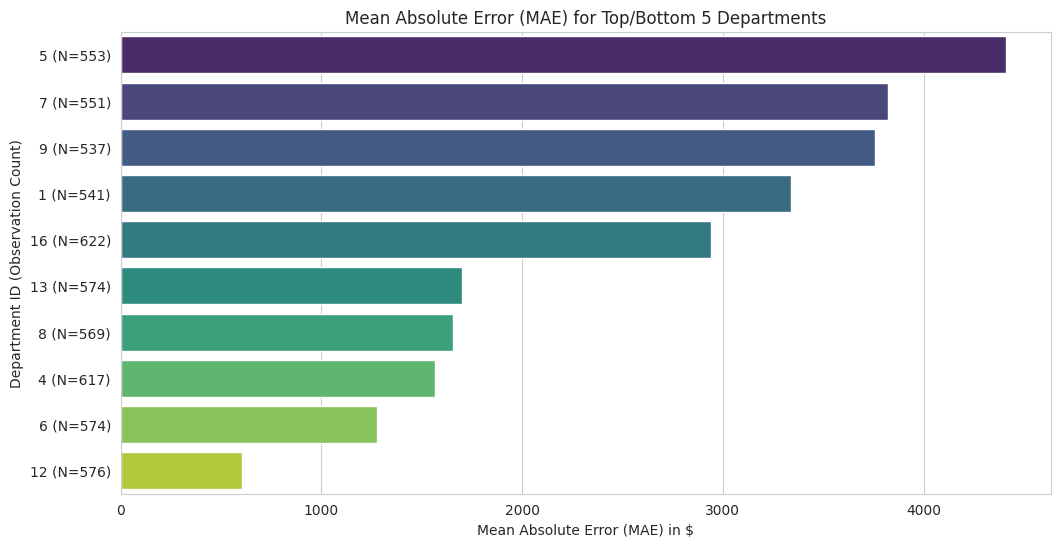

In [ ]:
# ==============================================================================
# 1. Error Analysis by Department
# ==============================================================================
print("\n--- 1. Error Analysis by Department (MAE) ---")

# Calculate Mean Absolute Error (MAE) for each Department
dept_error_metrics = error_analysis_df.groupby('Dept').agg(
    MAE=('Prediction_Error', 'mean'),
    Total_Actual_Sales=('Weekly_Sales', 'sum'),
    Count=('Dept', 'size')
).sort_values(by='MAE', ascending=False).reset_index()

# Calculate MAPE (Mean Absolute Percentage Error) for better comparison
dept_error_metrics['MAPE'] = (error_analysis_df.groupby('Dept')['Prediction_Error'].sum() / error_analysis_df.groupby('Dept')['Weekly_Sales'].sum()).values
dept_error_metrics = dept_error_metrics.sort_values(by='MAE', ascending=False)


print("\nTop 5 Departments by Mean Absolute Error (MAE):")
print(dept_error_metrics.head())
print("\nBottom 5 Departments by Mean Absolute Error (MAE):")
print(dept_error_metrics.tail())


# Plotting the MAE for the top and bottom departments
top_n = 5
plot_data = pd.concat([dept_error_metrics.head(top_n), dept_error_metrics.tail(top_n)])
plot_data['Dept_Label'] = plot_data['Dept'].astype(str) + ' (N=' + plot_data['Count'].astype(str) + ')'

plt.figure(figsize=(12, 6))
sns.barplot(x='MAE', y='Dept_Label', data=plot_data, palette='viridis')
plt.title(f'Mean Absolute Error (MAE) for Top/Bottom {top_n} Departments')
plt.xlabel('Mean Absolute Error (MAE) in $')
plt.ylabel('Department ID (Observation Count)')
plt.show()


--- 1. Error Analysis by Store (MAE) ---

Top 5 Stores by Mean Absolute Error (MAE):
   Store          MAE  Total_Actual_Sales  Count      MAPE
0     13  4197.186567         15588871.19    417  0.087141
1     20  4105.718970         17001263.70    433  0.074296
2     10  3924.132870         21316341.71    457  0.116564
3     19  3190.343822         12160901.74    450  0.075174
4      4  3079.040072         18226617.01    445  0.111674

Bottom 5 Stores by Mean Absolute Error (MAE):
    Store          MAE  Total_Actual_Sales  Count      MAPE
15     16  1735.891080          5784430.71    444  0.133243
16      7  1702.926118          5959194.12    411  0.146221
17      9  1439.149892          5698435.01    418  0.109470
18      3   958.503494          3478317.41    423  0.118055
19      5   834.835974          3027636.62    405  0.104567


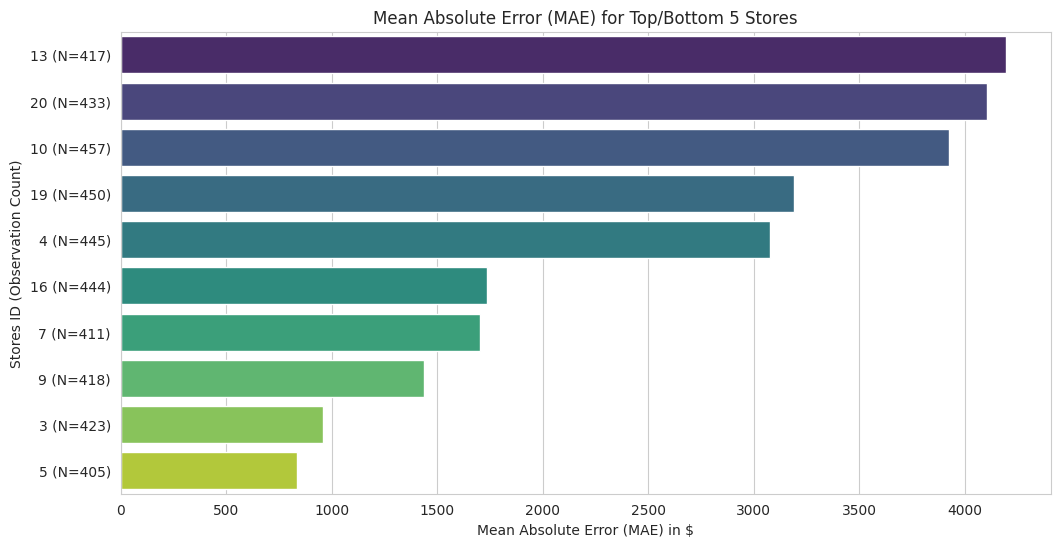

In [ ]:
# ==============================================================================
# 2. Error Analysis by Store
# ==============================================================================
print("\n--- 1. Error Analysis by Store (MAE) ---")

# Calculate Mean Absolute Error (MAE) for each Store
Store_error_metrics = error_analysis_df.groupby('Store').agg(
    MAE=('Prediction_Error', 'mean'),
    Total_Actual_Sales=('Weekly_Sales', 'sum'),
    Count=('Store', 'size')
).sort_values(by='MAE', ascending=False).reset_index()

# Calculate MAPE (Mean Absolute Percentage Error) for better comparison
Store_error_metrics['MAPE'] = (error_analysis_df.groupby('Store')['Prediction_Error'].sum() / error_analysis_df.groupby('Store')['Weekly_Sales'].sum()).values
Store_error_metrics = Store_error_metrics.sort_values(by='MAE', ascending=False)


print("\nTop 5 Stores by Mean Absolute Error (MAE):")
print(Store_error_metrics.head())
print("\nBottom 5 Stores by Mean Absolute Error (MAE):")
print(Store_error_metrics.tail())


# Plotting the MAE for the top and bottom stores
top_n = 5
plot_data = pd.concat([Store_error_metrics.head(top_n), Store_error_metrics.tail(top_n)])
plot_data['Store_Label'] = plot_data['Store'].astype(str) + ' (N=' + plot_data['Count'].astype(str) + ')'

plt.figure(figsize=(12, 6))
sns.barplot(x='MAE', y='Store_Label', data=plot_data, palette='viridis')
plt.title(f'Mean Absolute Error (MAE) for Top/Bottom {top_n} Stores')
plt.xlabel('Mean Absolute Error (MAE) in $')
plt.ylabel('Stores ID (Observation Count)')
plt.show()

ANALYSIS SUMMARY

1. **Feature Importance & Drivers of Sales**

XGBoost Analysis- Top drivers of sales:

rolling_mean_4w – most important (short-term momentum in sales)

lag_1_sales – previous week’s sales

rolling_mean_12w – longer-term trend

sharpe_4w – measure of volatility-adjusted performance

Markdown features (MarkDown1–5) are comparatively less influential, with MarkDown3 having the largest impact.

Insight: Short-term and lagged sales trends dominate sales prediction, but promotions can still contribute meaningfully.

2. **Promotion / Markdown Analysis**

ROI (Sales Impact per $1 Spent):

Best performing markdown: MarkDown3 (ROI ~ $0.10–$0.12 per $1)

Worst performing markdown: MarkDown2 (ROI negative, ~$-0.03 to $-0.05)

3. **Walmart Segmented Analysis**

Store Type Segmentation:

MarkDown3 consistently best across Store Types A and B.

MarkDown2 consistently worst.

Holiday vs Regular Periods:

Some markdowns like MarkDown2 gain during holidays despite negative baseline ROI.

MarkDown3 drops in effectiveness during holidays.

Insight: Tailor promotions not just by store but also by calendar period; what works normally may underperform in holidays.

4. **Macroeconomic / Causal Impact Analysis**

Economic features: Fuel_Price, CPI, Unemployment, Temperature

Feature importance: Unemployment > Temperature > Fuel_Price > CPI

Correlation with sales: All weak (|corr| < 0.2), indicating indirect or small linear effects.

Elasticity:

Temperature: +0.009% sales per 1% increase

Fuel_Price: +0.023% sales per 1% increase

CPI: -0.065% sales per 1% increase

Unemployment: -0.005% sales per 1% increase

Insight: Macroeconomic factors have measurable but modest effects on sales.

5. **Cash Flow Stability & Volatility Analysis**

Store-level stability (CV):

60% of stores are volatile (CV>0.6)

40% moderate (CV 0.3–0.6)

Top 5 most stable stores: CV ~0.545–0.579

Top 5 most volatile stores: CV ~0.706–0.749

Insight: Cash flow risk is significant at store levels; planning should focus on high-CV stores/departments.

6. **Revenue at Risk (VaR) Analysis**

Type A stores have higher mean sales but slightly higher risK.

Insight: VaR analysis complements volatility, identifying stores that could face extreme low sales, crucial for cash flow planning.


**THE END**